In [31]:
#!pip install pyLDAvis --user
import nltk
nltk.download('stopwords')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
import unidecode
from datetime import datetime, timedelta

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#import pyLDAvis.sklearn
from IPython.display import HTML
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from tqdm import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\giova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#opening data
df = pd.read_csv('tweets_radar_covid.csv', low_memory=False)
df = df.sort_values(by='Usuário', ascending=False)
df = df.drop_duplicates(subset='ID', keep='first')
df = df.drop(columns = ['Unnamed: 0'])
df['Data da Publicação'] = pd.to_datetime(df['Data da Publicação'])

#keeping only data from after 01/08/2020
df = df[df['Data da Publicação'] > '2020-08-01']

#create index indicating week
first_monday = datetime.strptime('2020-08-03', '%Y-%m-%d')
first_monday_ = (first_monday - timedelta(days = first_monday.weekday()))
def date_to_weekind(x):
    monday = (x - timedelta(days = x.weekday()))
    return int((monday - first_monday_).days/7)
df['week-ind'] = df['Data da Publicação'].apply(date_to_weekind)

#popularity value
df['Popularidade'] = [ a + b for a,b in zip(df['Nᵒ de Curtidas'] , df['Nᵒ de Compartilhamentos'])]

Index(['ID', 'Conteúdo da Publicação', 'Data da Coleta', 'Data da Publicação',
       'Nᵒ de Curtidas', 'Nᵒ de Compartilhamentos', 'Nᵒ de Seguidores',
       'Nᵒ Seguindo', 'Total de Publicações', 'Data da Criação da Conta',
       'Hashtags', 'Nota Atribuída', 'URL', 'Usuário', 'week-ind',
       'Popularidade', 'clean_tweet'],
      dtype='object')

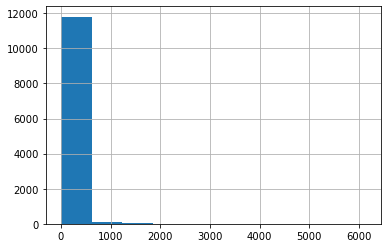

In [68]:
df[(df['Nᵒ de Compartilhamentos'] > 5)]['Nᵒ de Compartilhamentos'].hist()

In [58]:
(df['Conteúdo da Publicação'].apply(lambda x : len(x.split(" "))) <= 5).sum()

4062

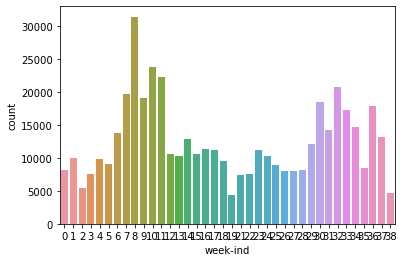

In [9]:
sns.countplot(df['week-ind'])
plt.show()

In [34]:
#cleaning tweets
def clean_tweets(text):
    #remove emoticons
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    text = emoticon_pattern.sub(r"", text)
    
    #remove urls
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    
    #remove wrong urls
    text = re.sub(r'^https?\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    return text

df['clean_tweet'] = df['Conteúdo da Publicação'].progress_apply(clean_tweets)
doc_raw = df['clean_tweet']

100%|████████████████████████████████████████████████████████████████████████| 471500/471500 [02:23<00:00, 3292.50it/s]


In [35]:
doc_raw

82011      @SantoroDebs É uma gripezinha 😆 https/t.co/PSy...
186817     Eles querem morrer com dinheiro no bolso! \n#C...
335228     quem quiser os prints da bizarrice curte essa ...
385365     IMAGINA O DESESPERO DOS CORRUPTOS HOJE\nPREFEI...
203274          @loucareality o fã da miss cloroquina kkkkk 
                                 ...                        
1516798    @MubarakLuiza Bora fazer uma campanha para inc...
1516799    @oswaldojor Esse general nunca esteve ao lado ...
1516800                     @TSEjusbr Cadê o voto impresso?.
1516801    @GuilhermeBoulos Boulos, estou torcendo por ms...
1536834    @ALFRA_RF SP tá condenada 🤦\nOpções péssimo, p...
Name: clean_tweet, Length: 471500, dtype: object

In [36]:
#create features
STOPWORDS = nltk.corpus.stopwords.words('portuguese')
STOPWORDS = [unidecode.unidecode(x) for x in STOPWORDS]
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                analyzer='word', 
                                stop_words = STOPWORDS,
                                ngram_range = (1,1),
                                lowercase = True,
                                token_pattern = r'\b[a-z]{4,}\b',
                                max_df = 0.3, 
                                min_df = 0.01
                                )
dtm_tf = tf_vectorizer.fit_transform(doc_raw)
features = tf_vectorizer.get_feature_names() 

In [39]:
lda_model = LatentDirichletAllocation(n_components=6, max_iter=10, learning_method='online', verbose = 1)
lda_model.fit_transform(dtm_tf)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


array([[0.38867557, 0.05610334, 0.3875227 , 0.05594153, 0.0562013 ,
        0.05555556],
       [0.02777778, 0.02786236, 0.02809589, 0.02783821, 0.86064798,
        0.02777778],
       [0.30213013, 0.1757383 , 0.12962967, 0.01851852, 0.35546486,
        0.01851852],
       ...,
       [0.05555556, 0.05555556, 0.38888897, 0.05555556, 0.05555556,
        0.38888881],
       [0.08333333, 0.08333333, 0.58333333, 0.08333333, 0.08333333,
        0.08333333],
       [0.08333333, 0.08333333, 0.58333333, 0.08333333, 0.08333333,
        0.08333333]])

In [44]:
lda_model.fit_transform(dtm_tf)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10


KeyboardInterrupt: 

In [40]:
topics = []
for i_topic in range(6):
    prob_dict = {}
    topic_probs = (lda_model.components_/lda_model.components_.sum(axis=1)[:, np.newaxis])[i_topic, :]
    biggest_probs_inds = np.argpartition(topic_probs, -15)[-15:]
    for i in biggest_probs_inds:
        prob_dict[features[i]] = topic_probs[i]
    topics.append(prob_dict)

In [41]:
topics

[{'fada': 0.02458907986181963,
  'auge': 0.02472839635794901,
  'sorriso': 0.024964245282792112,
  'corona': 0.025114702236765648,
  'joao': 0.025924032743763255,
  'corno': 0.027250648826091375,
  'celular': 0.02523808398407358,
  'recife': 0.028748125331029932,
  'noia': 0.028818917811851346,
  'quer': 0.03391874773084686,
  'vassoura': 0.028802586743753866,
  'pessoa': 0.031923128166800194,
  'gripezinha': 0.04493383941921978,
  'maconha': 0.031781731535376806,
  'quarentena': 0.03221379294043098},
 {'deve': 0.017072481230716693,
  'aqui': 0.01724332006096481,
  'gado': 0.019258972554420658,
  'disse': 0.020717119946376962,
  'outros': 0.02015772040561586,
  'ficar': 0.02189999096300947,
  'pior': 0.02201101945938862,
  'covid': 0.027229091698366882,
  'ivermectina': 0.027298073468796008,
  'contra': 0.0716779570450861,
  'chines': 0.08528515987028004,
  'virus': 0.1662498603290574,
  'cloroquina': 0.10671722689529511,
  'votar': 0.030927484387989933,
  'https': 0.028185606800227837

In [43]:
df[df.Hashtags != "-"]

,ID,Conteúdo da Publicação,Data da Coleta,Data da Publicação,Nᵒ de Curtidas,Nᵒ de Compartilhamentos,Nᵒ de Seguidores,Nᵒ Seguindo,Total de Publicações,Data da Criação da Conta,Hashtags,Nota Atribuída,URL,Usuário,week-ind,Popularidade,clean_tweet
186817,1367472323612270597,Eles querem morrer com dinheiro no bolso! \n#C...,2021-03-04 14:25:00,2021-03-04 13:49:00,0,0,805,1385,31904,06/03/2012 - 22:19,#Covid_19 #COVID2019 #BolsonarismoMata #Bolson...,4.15,https://twitter.com/zzzfabiano/status/13674723...,zzzfabiano,30,0,Eles querem morrer com dinheiro no bolso! \n#C...
96917,1359169301362733060,Fui diagnosticado com covid e graças ao nosso ...,2021-02-09 16:46:00,2021-02-09 15:56:00,0,0,46,211,1400,30/11/2017 - 00:43,#BolsonaroGenocida,3.54,https://twitter.com/zyroniano/status/135916930...,zyroniano,27,0,Fui diagnosticado com covid e graças ao nosso ...
180846,1368070491928461315,@marianacabralc IVERMECTINA\nOZÔNIO RETAL\nCLO...,2021-03-06 05:33:00,2021-03-06 05:26:00,0,0,34,77,1748,27/01/2016 - 14:18,#TragamAsAmantesJunto,4.23,https://twitter.com/zxMath/status/136807049192...,zxMath,30,0,@marianacabralc IVERMECTINA\nOZÔNIO RETAL\nCLO...
171129,1368065109294211073,@srgadoaldo @revistaoeste @augustosnunes Sou e...,2021-03-06 05:33:00,2021-03-06 05:05:00,1,0,34,77,1748,27/01/2016 - 14:18,#ForaDilma,4.23,https://twitter.com/zxMath/status/136806510929...,zxMath,30,1,@srgadoaldo @revistaoeste @augustosnunes Sou e...
404399,1386686290087788549,Será que hoje a ANVISA vai liberar a vacina ru...,2021-04-26 14:22:00,2021-04-26 14:19:00,0,0,50,241,1174,20/03/2015 - 18:24,#STFVergonhaNacional,3.54,https://twitter.com/zuzalina47/status/13866862...,zuzalina47,38,0,Será que hoje a ANVISA vai liberar a vacina ru...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516714,1309238726451695618,"@WendelBrasilSP Misericórdia, com essa lista d...",2020-09-24 21:16:00,2020-09-24 21:10:00,0,0,129,206,832,22/08/2010 - 22:59,#ComunismoNão,3.85,NaN,NaN,7,0,"@WendelBrasilSP Misericórdia, com essa lista d..."
1516726,1309255616716734466,@claudioedantas Essa reforma é um #DesmontedoE...,2020-09-24 22:34:00,2020-09-24 22:17:00,0,2,22,67,2784,07/09/2020 - 11:34,#DesmontedoEstado,2.15,NaN,NaN,7,2,@claudioedantas Essa reforma é um #DesmontedoE...
1516740,1309254632103915521,Esse desgoverno deu a largada para o fim dos c...,2020-09-24 22:15:00,2020-09-24 22:13:00,0,1,2,8,187,08/09/2020 - 16:01,#DesmontedoEstado,3.23,NaN,NaN,7,1,Esse desgoverno deu a largada para o fim dos c...
1516751,1309265246746480641,@GuilhermeBoulos #BOLSONARO2022. PT PSOL VÃO P...,2020-09-24 23:10:00,2020-09-24 22:55:00,0,0,1,1,7,01/10/2019 - 22:38,#BOLSONARO2022,3.62,NaN,NaN,7,0,@GuilhermeBoulos #BOLSONARO2022. PT PSOL VÃO P...


In [11]:
# function to select top k most popular tweets from week
def pick_k (semana, k=10):
    subset = df[df['Semana_análise'] == str(semana)]
    subset = subset.sort_values(by='Popularidade', ascending=False).head(k)
    return subset

def pick_mes (mes, k=10):
    subset = df[df['Mes_análise'] == str(mes)]
    subset = subset.sort_values(by='Popularidade', ascending=False).head(k)
    return subset


In [14]:
dados = [pick_k(a,k=10) for a in lista_semanas]
dados = pd.concat(dados)
len(dados)

405

In [24]:


dados['Conteúdo da Publicação'] = dados['Conteúdo da Publicação'].apply(str)
dados['Conteúdo da Publicação'] = dados['Conteúdo da Publicação'].apply(remove_emoticons)
docs_raw = dados['Conteúdo da Publicação']

#remove stopwords
STOPWORDS = stopwords.words('portuguese').sort()


In [38]:
tf_vectorizer.get_feature_names()

['agora',
 'ainda',
 'anvisa',
 'aplauso',
 'aqui',
 'assim',
 'bolsonaro',
 'brasil',
 'brasileira',
 'brasileiro',
 'brasileiros',
 'cara',
 'casa',
 'casos',
 'causa',
 'china',
 'chines',
 'chinesa',
 'cloroquina',
 'como',
 'comunista',
 'contra',
 'coronavac',
 'coronavirus',
 'covid',
 'dados',
 'deixe',
 'depois',
 'dinheiro',
 'disse',
 'dizer',
 'doria',
 'eficacia',
 'esquerda',
 'essa',
 'esse',
 'esta',
 'estado',
 'estados',
 'estao',
 'fake',
 'fazer',
 'federal',
 'fosse',
 'globo',
 'governador',
 'governadores',
 'governo',
 'grande',
 'gripezinha',
 'hidroxicloroquina',
 'hoje',
 'https',
 'imprensa',
 'isso',
 'ivermectina',
 'jairbolsonaro',
 'joao',
 'lockdown',
 'maior',
 'mais',
 'menos',
 'mentira',
 'mesmo',
 'midia',
 'milhoes',
 'minha',
 'ministro',
 'morte',
 'mortes',
 'mortos',
 'muito',
 'mundo',
 'news',
 'ninguem',
 'nunca',
 'onde',
 'pais',
 'pandemia',
 'parabens',
 'paulo',
 'pazuello',
 'pela',
 'pelo',
 'pessoa',
 'pessoas',
 'pode',
 'populacao

In [35]:
len(features)

118

topic: 0
esta 0.031211727589620923
cloroquina 0.0333810874199771
vacina 0.034855911266424795
aqui 0.03581717023657004
hoje 0.036304235146712105
ivermectina 0.03998659781933839
quem 0.13374469739804837
bolsonaro 0.038474322034337795
brasil 0.039788642840843616
covid 0.04375253819482058

topic: 1
imprensa 0.022657826522358634
como 0.04026214280130694
pelo 0.03992380923030006
chines 0.06840715305173621
contra 0.04370607522247724
covid 0.02378962296095772
news 0.024859184021594413
fake 0.02629583742127921
virus 0.08370113999397945
coronavirus 0.02597916551708933

topic: 2
prefeitos 0.025036803199218673
governadores 0.027234251518882265
sobre 0.025072522293441903
pandemia 0.027939287293934502
cloroquina 0.03327594474062058
https 0.03696584926390739
esta 0.037104691092433376
covid 0.058472075406023984
bolsonaro 0.06959291833384312
presidente 0.11475082146448677

topic: 3
prefeito 0.03152868066762889
governador 0.03213259811861234
dinheiro 0.03391768820030055
precoce 0.03595522818995249
trata

In [18]:
# Transformar as predições LDA em coordenadas cartesianas de chegada
def lda_to_cartesian (predicts):
    angle = 2*np.pi/len(predicts.columns)
    angles = [(i+1)*angle for i in predicts.columns]
    angles = np.array(angles)
    anglesx =np.cos(angles)
    anglesy = np.sin(angles)
    xlist = []
    ylist = []
    for row in range(len(predicts)):
        vectors_r = [predicts.iloc[row,i] for i in predicts.columns]
        vectors_r = np.array(vectors_r)
        x = np.sum(anglesx*vectors_r)
        y = np.sum(anglesy*vectors_r)
        xlist.append(x)
        ylist.append(y)
        
    return xlist, ylist

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# acrescentas os predicts LDA e cordenadas cartesianas à tabela de dados

predicts = pd.DataFrame(lda_Z)
predicts.index = dados.index

position = lda_to_cartesian(predicts)
position = pd.DataFrame(position).transpose()
position.columns = ['x','y']
position.index = dados.index


frames = [dados, predicts, position]
dados = pd.concat(frames, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# exportar Json Visualização 1 (tweets + corrdenadas)
dados.to_json('dados.json', orient='records')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
panel.token_table

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic,Freq,Term
term,,,
0,1,0.180249,agora
0,2,0.240332,agora
0,3,0.030041,agora
0,4,0.210290,agora
0,5,0.270373,agora
...,...,...,...
116,5,0.214461,virus
117,1,0.372667,voce
117,3,0.186334,voce


In [31]:
panel.topic_info

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Term,Freq,Total,Category,logprob,loglift
96,quem,40.000000,40.000000,Default,30.0000,30.0000
98,saude,33.000000,33.000000,Default,29.0000,29.0000
111,vacina,66.000000,66.000000,Default,28.0000,28.0000
116,virus,51.000000,51.000000,Default,27.0000,27.0000
45,governador,22.000000,22.000000,Default,26.0000,26.0000
...,...,...,...,...,...,...
47,governo,2.812028,30.918490,Topic6,-4.5053,-0.0349
104,todos,0.838133,9.407349,Topic6,-5.7157,-0.0555
40,fake,1.554148,17.758207,Topic6,-5.0982,-0.0733
73,news,1.441620,16.923958,Topic6,-5.1734,-0.1004
